In [1]:
import omnitool
from omnitool.literature_values import *
import barbershop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
'''We'll use the asteroseismic data from Yu et al. 2018'''
#Read in Jie Yu
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table1.txt'
yu18_1 = pd.read_csv(sfile, sep='|')
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table2.txt'
yu18_2 = pd.read_csv(sfile, sep='|')
df = pd.merge(yu18_1, yu18_2, on='KICID',how='outer')
df.rename(columns={'KICID':'KIC',
                    'EvoPhase':'stage',
                    'err_x':'numax_err',
                    'err.1_x':'dnu_err',
                    'err_y':'Teff_err',
                     'Fe/H':'[Fe/H]',
                    'err.2_y':'[Fe/H]_err',
                    'err.1_y':'logg_err',
                    'err.3_y':'M_err',
                    'err.4_y':'R_err'},inplace=True) #For consistency
df.head(2)

,KIC,kepmag,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,M_RGB,err.5,R_RGB,err.6,M_Clump,err.7,R_Clump,err.8,stage,Unnamed: 20
0,757137,9.20,17,1308.7,29.99,0.60,3.399,0.011,104.9,4.6,...,1.55,0.13,13.26,0.39,1.72,0.14,13.97,0.41,1,NaN
1,892010,11.67,4,206.3,17.85,0.89,2.427,0.078,196.0,20.5,...,1.36,0.28,16.02,1.34,1.43,0.30,16.47,1.39,0,NaN


In [3]:
#Lets run the scaling relations
sc = omnitool.scalings(df, df.numax, df.dnu, df. Teff,\
                       _numax_err = df.numax_err, _dnu_err = df.dnu_err,\
                       _Teff_err = df.Teff_err)

df['R'] = sc.get_radius()/Rsol
df['R_err'] = sc.get_radius_err()/Rsol
df['M'] = sc.get_mass()/Msol
df['M_err'] = sc.get_mass_err()/Msol
df['logg'] = sc.get_logg()
df['logg_err'] = sc.get_logg_err()
df['L'] = sc.get_luminosity()/Lsol
df['L_err'] = sc.get_luminosity_err()/Lsol
df['Mbol'] = sc.get_bolmag()
df['Mbol_err'] = sc.get_bolmag_err()

In [4]:
#Lets get the bolometric corrections in K, J, and H
#Per Salaris et al. 1993, [M/H] = [Fe/H] + log(0.638*fa + 0.362)
#where fa is the alpha abundance. We will assume for now that fa = 1
#Therefore, [Fe/H] == [M/H]
Z = Zsol * 10 ** df['[Fe/H]'].values
Teff = df.Teff.values
L = df.L.values
logg = df.logg.values

get_bc = omnitool.bolometric_correction(Teff,\
                                       logg,\
                                       L,\
                                       Z)

In [5]:
#Lets get and apply the bolometric corrections
KBC = get_bc(band='Ks')
HBC = get_bc(band='H')
JBC = get_bc(band='J')

100%|██████████| 16094/16094 [00:08<00:00, 1916.65it/s]


In [6]:
#Calculate absolute magnitudes and appropriate error
df['MKs'] = df.Mbol - KBC
df['MH'] = df.Mbol - JBC
df['MJ'] = df.Mbol - HBC
df['absmag_err'] = np.sqrt(df.Mbol_err**2 + err_bc**2)

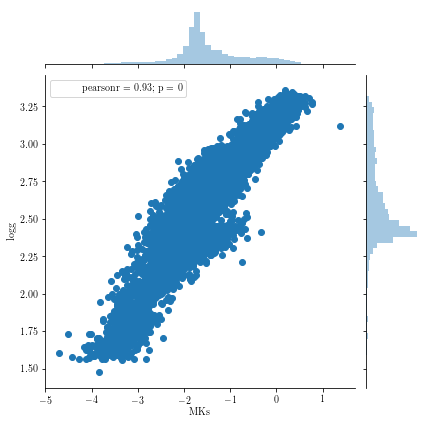

In [7]:
sns.jointplot(df.MKs,df.logg)
plt.show()


In [11]:
%pylab qt
barber = barbershop.open(df,'MH','logg')
barber.add_client('stage')
barber.add_client('M')
barber.add_client('[Fe/H]')
barber.add_client('R')
barber.histograms_on(x=True, y=True)
barber.show_mirror()

Populating the interactive namespace from numpy and matplotlib
Number of seats in use : 1/5.
Number of seats in use : 2/5.
Number of seats in use : 3/5.
Number of seats in use : 4/5.
